# Анализ каналов привлечения пользователей в развлекательном приложении Procrastinate Pro+

# Описание проекта

Провести исследование развлекательного приложения Procrastinate Pro+ и выяснить почему, несмотря на существенные маркетинговые вложения, компания терпит убытки в последние несколько месяцев и помочь компании выйти в плюс.

# План работы:
1. Загрузка и предобработка данных
2. Функции для работы с данными
3. Исследовательский анализ данных
4. Анализ расходов на маркетинг
5. Окупаемость рекламы
    * Общая окупаемость рекламы
    * Конверсия и удержание пользователей
    * Окупаемость, конверсия и удержание в разрезе устройств
    * Окупаемость, конверсия и удержание в разрезе стран
    * Окупаемость, конверсия и удержание в разрезе каналов привлечения
    * Окупаемость, конверсия и удержание в США
6. Общий вывод и рекомендации

# Описание данных

Для проведения анализа нам были предоставлены три датасета с данными о пользователях, привлеченных  в период с 1 мая по 27 октября 2019. <br>
visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, <br>
orders_info_short.csv — информацию о заказах, а файл <br> costs_info_short.csv — информацию о расходах на рекламу.

Структура файла `visits_info_short.csv`:<br>
- `User Id` - уникальный идентификатор пользователя,
- `Region` - страна пользователя,
- `Device` - тип устройства пользователя,
- `Channel` - идентификатор источника перехода,
- `Session Start` - дата и время начала сессии,
- `Session End` - дата и время окончания сессии.

Структура файла `orders_info_short.csv`:<br>
- `User Id` - уникальный идентификатор пользователя,
- `Event Dt` - дата и время покупки,
- `Revenue` - сумма заказа.

Структура файла `costs_info_short.csv`:<br>
- `dt` - уникальный идентификатор пользователя,
- `Channel` - дата и время покупки,
- `costs` - сумма заказа.

# Загрузим данные и подготовим их к анализу

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime, timedelta
import calendar

In [3]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

<b> Проведем первичную оценку данных, а также оценим наличие пропусков и дубликатов </b>

In [4]:
dataframes = {
    'visits': visits,
    'orders': orders,
    'costs': costs
}

for name, df in dataframes.items():
    print('Датафрейм', name)
    print('-' * 20)
    print(df.info())
    display('Первые пять строк датафрейма', df.head())
    print('')

Датафрейм visits
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


'Первые пять строк датафрейма'

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



Датафрейм orders
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


'Первые пять строк датафрейма'

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



Датафрейм costs
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


'Первые пять строк датафрейма'

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Пропусков в данных не выявлено, при этом столбцы, содержащие значения с датами (session_start, session_end, event_dt, dt), имеют тип данных object.
Позднее урегулируем данный момент и изменим тип данных в указанных столбцах.

<b> Проверим данные на наличие дубликатов: </b>

In [11]:
for column in visits.columns:
    print(column, visits[column].duplicated().sum())

User Id 159893
Region 309897
Device 309897
Channel 309890
Session Start 3088
Session End 3108


In [12]:
for column in orders.columns:
    print(column, orders[column].duplicated().sum())

User Id 31331
Event Dt 49
Revenue 40207


In [13]:
for column in costs.columns:
    print(column, costs[column].duplicated().sum())

dt 1620
Channel 1790
costs 1192


<b> Изменим вариант проверки на дубликаты (т.к. у нас имеется незначительное число уникальных значений в ряде столбцов и однозначно ответить о наличии / отсутствии в дубликатах в данных по проведенной выше проверке не предоставляется возможным). Кроме того в таблице visits дубликатами будем считать строки имеющие одинаковые идентификатор пользователя и время начала сессии </b>

In [14]:
dup = visits[visits.duplicated(subset=('User Id', 'Session Start'))].size
display(f'Количество дубликатов в таблице visits - {dup}')

'Количество дубликатов в таблице visits - 0'

In [15]:
display(f'Число дубликатов в таблице orders - {orders[orders.duplicated()].size}')

'Число дубликатов в таблице orders - 0'

In [16]:
display(f'Число дубликатов в таблице costs - {costs[costs.duplicated()].size}')

'Число дубликатов в таблице costs - 0'

<b> Проанализируем частоту присутствия тех или иных значений данных в предоставленных нам для анализа датафреймах </b>

In [17]:
def value_counts(data: pd.DataFrame,  column: str):
    """
    Выводит на экран частоту присутствия значений в столбцах с помощью метода value_counts
    """
    print('')
    print(f'Частота встречаемых значений - {column}')
    print('-' * 45)
    display(data[column].value_counts().reset_index().rename(columns={'index': 'value', column:'value_count'})
           )
    print()

In [18]:
for data in (visits, orders, costs):
    for column in data.columns:
        value_counts(data, column)


Частота встречаемых значений - User Id
---------------------------------------------


,value,value_count
0,33606575057,46
1,943775408561,36
2,901180916748,35
3,870784569391,34
4,764086596354,33
...,...,...
150003,350468480225,1
150004,748123264144,1
150005,909267360937,1
150006,816252757222,1




Частота встречаемых значений - Region
---------------------------------------------


,value,value_count
0,United States,207327
1,UK,36419
2,France,35396
3,Germany,30759




Частота встречаемых значений - Device
---------------------------------------------


,value,value_count
0,iPhone,112603
1,Android,72590
2,PC,62686
3,Mac,62022




Частота встречаемых значений - Channel
---------------------------------------------


,value,value_count
0,organic,107760
1,TipTop,54794
2,FaceBoom,49022
3,WahooNetBanner,20465
4,LeapBob,17013
5,OppleCreativeMedia,16794
6,RocketSuperAds,12724
7,YRabbit,9053
8,MediaTornado,8878
9,AdNonSense,6891




Частота встречаемых значений - Session Start
---------------------------------------------


,value,value_count
0,2019-10-22 17:17:39,3
1,2019-10-10 22:50:07,3
2,2019-08-26 02:33:54,3
3,2019-10-26 12:40:03,3
4,2019-06-27 14:56:41,3
...,...,...
306808,2019-06-18 21:12:23,1
306809,2019-06-14 14:47:13,1
306810,2019-06-17 19:44:45,1
306811,2019-05-14 10:50:19,1




Частота встречаемых значений - Session End
---------------------------------------------


,value,value_count
0,2019-05-30 19:35:13,3
1,2019-09-29 17:32:12,3
2,2019-05-28 14:36:05,3
3,2019-10-25 07:28:19,3
4,2019-08-04 12:14:49,3
...,...,...
306788,2019-10-15 00:43:17,1
306789,2019-10-19 09:43:16,1
306790,2019-06-20 01:12:44,1
306791,2019-05-11 19:40:26,1




Частота встречаемых значений - User Id
---------------------------------------------


,value,value_count
0,901180916748,22
1,883098437811,20
2,75337957494,19
3,512471511263,19
4,295795879965,19
...,...,...
8876,237296010927,1
8877,319939546352,1
8878,742075710598,1
8879,202972423389,1




Частота встречаемых значений - Event Dt
---------------------------------------------


,value,value_count
0,2019-10-05 21:30:50,2
1,2019-10-13 23:40:44,2
2,2019-09-29 09:03:24,2
3,2019-10-11 20:55:22,2
4,2019-09-08 03:45:39,2
...,...,...
40158,2019-10-06 00:54:20,1
40159,2019-08-03 14:29:49,1
40160,2019-06-02 03:25:43,1
40161,2019-05-15 21:41:11,1




Частота встречаемых значений - Revenue
---------------------------------------------


,value,value_count
0,4.99,38631
1,5.99,780
2,9.99,385
3,49.99,212
4,19.99,204




Частота встречаемых значений - dt
---------------------------------------------


,value,value_count
0,2019-05-11,10
1,2019-06-28,10
2,2019-07-27,10
3,2019-10-24,10
4,2019-08-03,10
...,...,...
175,2019-05-01,10
176,2019-09-04,10
177,2019-07-05,10
178,2019-06-10,10




Частота встречаемых значений - Channel
---------------------------------------------


,value,value_count
0,LeapBob,180
1,AdNonSense,180
2,TipTop,180
3,MediaTornado,180
4,lambdaMediaAds,180
5,WahooNetBanner,180
6,RocketSuperAds,180
7,YRabbit,180
8,FaceBoom,180
9,OppleCreativeMedia,180




Частота встречаемых значений - costs
---------------------------------------------


,value,value_count
0,6.40,26
1,3.36,21
2,9.60,20
3,16.80,19
4,4.32,17
...,...,...
603,217.80,1
604,186.20,1
605,176.70,1
606,273.00,1


<b> Дополнительно приведем названия столбцов к нижнему регистру и заменим в названии столбцов пробелы на нижнее подчеркивание

In [22]:
visits.rename(columns=str.lower, inplace=True)
orders.rename(columns=str.lower, inplace=True)
costs.rename(columns=str.lower, inplace=True)

In [23]:
visits.columns = visits.columns.str.replace(" ", "_")
orders.columns = orders.columns.str.replace(" ", "_")
costs.columns = costs.columns.str.replace(" ", "_")

<b> Исправим тип данных в столбцах session_start, session_end, event_dt, dt на datetime.

In [25]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

<a id="functions"></a>
# Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [27]:
def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles 

<a id="analysis"></a>
# Исследовательский анализ данных

Создадим таблицу с профилями пользователей, используя ранее написанную функцию get_profiles. <br>
А также определим минимальную и максимальную даты привлечения пользователей.

In [42]:
profiles = get_profiles(visits, orders, costs)
display(profiles)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [44]:
min_dt = profiles['dt'].min()
max_dt = profiles['dt'].max()
display(f'Минимальная дата - {min_dt}')
display(f'Максимальная дата привлечения пользователей - {max_dt}')

'Минимальная дата - 2019-05-01'

'Максимальная дата привлечения пользователей - 2019-10-27'

Предельные даты соответствуют условиям предоставленного нам задания.

<b> Определим из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [45]:
profiles['region'].value_counts()

United States    100002
UK                17575
France            17450
Germany           14981
Name: region, dtype: int64

In [46]:
profiles.query('payer == True')['region'].value_counts()

United States    6902
UK                700
France            663
Germany           616
Name: region, dtype: int64

In [47]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id',ascending=False) \
.rename(columns={'user_id': 'number_of_users','payer': 'share_of_payers'}).style.format("{:.2%}",subset='share_of_payers')

,number_of_users,share_of_payers
region,,
United States,100002,6.90%
UK,17575,3.98%
France,17450,3.80%
Germany,14981,4.11%


<b> Вывод: </b> пользователи приложения расположены в 4х странах - США, ФРГ, Франция и Великобритания. Подавляющее число пользователей приходится на США, на которые приходится также и максимальная доля платящих пользователей от общего числа пользователей.

<b> Определим какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [49]:
profiles_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id',ascending=False) \
.rename(columns={'user_id': 'number_of_users','payer': 'share_of_payers'})
display(profiles_device.style.format("{:.2%}",subset='share_of_payers'))

,number_of_users,share_of_payers
device,,
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%
Mac,30042,6.36%


In [50]:
profiles_device['number_of_payers'] = (profiles_device['number_of_users'] * profiles_device['share_of_payers']).astype('int')
display(profiles_device.style.format("{:.2%}",subset='share_of_payers'))

,number_of_users,share_of_payers,number_of_payers
device,,,
iPhone,54479,6.21%,3382
Android,35032,5.85%,2050
PC,30455,5.05%,1537
Mac,30042,6.36%,1912


<b> Вывод: </b> пользователи приложения пользуются iPhone, Android, PC и устройствами на базе Mac. Лидирует по общему числу пользователей и числу платящих пользователей - iPhone. Доля платящих пользователей самая высокая у устройств на базе Mac, которая несущественно опережает iPhone, следующий на втором месте.

<b> Профили пользователей: в разрезе рекламных источников.

In [54]:
profiles_channel = profiles.pivot_table(index='channel', values='payer', aggfunc = ['count', 'mean', 'sum'])
profiles_channel.columns = ['number_of_users','share_of_payers','number_of_payers']
profiles_channel.sort_values('number_of_payers', ascending = False).style.format("{:.2%}",subset='share_of_payers')

,number_of_users,share_of_payers,number_of_payers
channel,,,
FaceBoom,29144,12.20%,3557
TipTop,19561,9.60%,1878
organic,56439,2.06%,1160
WahooNetBanner,8553,5.30%,453
AdNonSense,3880,11.34%,440
RocketSuperAds,4448,7.91%,352
LeapBob,8553,3.06%,262
OppleCreativeMedia,8605,2.71%,233
lambdaMediaAds,2149,10.47%,225


<b> Вывод: </b> общее число каналов привлечения пользователей - 11, в том числе: 10 платных, 1 бесплатный (organic). Большая часть пользователей пришла бесплатно, при это доля платящих пользователей среди "бесплатных" пользователей - наименьшая. Лидером по количеству и доле платящих пользователей является FaceBoom. Из числа лидеров можно обратить внимание также на TipTop (2-ое место по количеству платящих пользователей, 3-е с т.зр. общего числа пользователей) и AdNonSense (2-ое место с т.зр. доли платящих пользователей).

<a id="marketing"></a>
# Исследуем маркетинг

In [57]:
costs.costs.sum()
display(f'Общая сумма расходов на маркетинг - {costs.costs.sum():.2f}')

'Общая сумма расходов на маркетинг - 105497.30'

<b> Затраты в разрезе рекламных источников

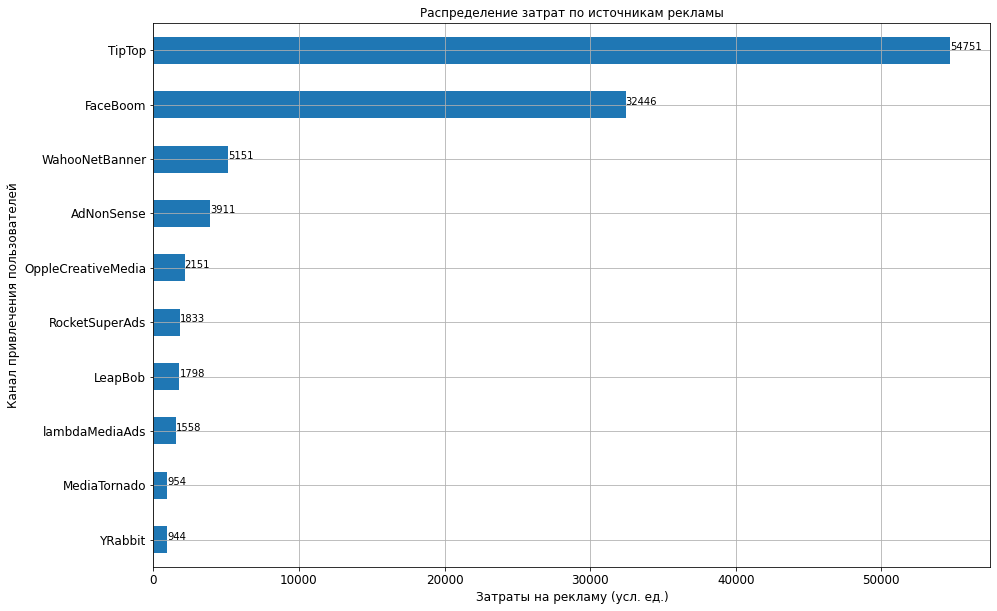

In [62]:
data = costs.groupby('channel').costs.sum().sort_values(ascending=True)

data.plot(
    kind='barh',
    figsize=(15,10),
    grid=True,
    fontsize=12,  
)
for i, val in enumerate(data.values):
    plt.text(val, i, round(float(val)))
            
plt.title('Распределение затрат по источникам рекламы', fontsize=12)
plt.xlabel('Затраты на рекламу (усл. ед.)', fontsize=12)
plt.ylabel('Канал привлечения пользователей', fontsize=12)
plt.show()

<b> Вывод: </b> наиболее затратным источником является TipTop: затраты на TipTop в 1,7 раза превышают затраты на FaceBoom, при этом из канала TipTop привлечено фактически в два раза меньше платящих пользователей, чем из канала FaceBoom (1878 против 3557). Затраты на FaceBoom в свою очередь в разы превышают затраты на идущий следующим в списке источник - WahooNetBanner (32446 усл.ед. против 5151 усл.ед). 

<b> Динамика изменения расходов во времени в разрезе источников

Предварительно добавим в таблицу costs столбцы с данными о неделях и месяцах для проведения анализа выше.

In [63]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

Оценим предельные границы недель и месяцев, в разрезе которых мы будем делать анализ (год = 2019)

In [65]:
costs['week'].agg({'min', 'max'})

max    43
min    18
Name: week, dtype: int64

In [66]:
costs['month'].agg({'min', 'max'})

max    10
min     5
Name: month, dtype: int64

Text(0.5, 1.0, 'Dynamics of changes in adcosts in division to sources by months')

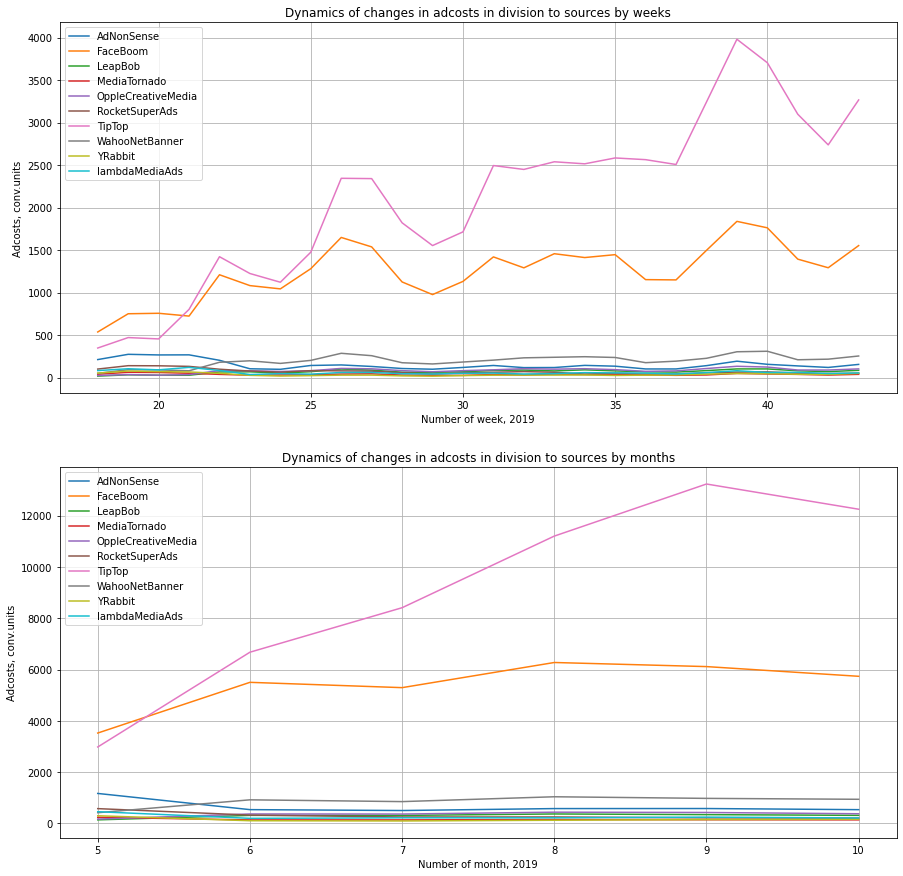

In [68]:
plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2, 1, 1)
costs.pivot_table(index='channel', columns = 'week', values='costs', aggfunc = sum).T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Number of week, 2019')
plt.ylabel('Adcosts, conv.units')
plt.title('Dynamics of changes in adcosts in division to sources by weeks')

ax2 = plt.subplot(2, 1, 2)
costs.pivot_table(index='channel', columns = 'month', values='costs', aggfunc = sum).T.plot(grid=True, ax=ax2)
plt.legend(loc=0)
plt.xlabel('Number of month, 2019')
plt.ylabel('Adcosts, conv.units')
plt.title('Dynamics of changes in adcosts in division to sources by months')

<b> Вывод: </b> затраты по каналу TipTop выросли более чем в 6 раз в еженедельной динамике, по каналу FaceBoom приблизительно в 3 раза. 
Расходы на остальные каналы существенно не изменились, а снижение затрат на AdNonSense фактически компенсировалось ростом затрат на WahooNetBanner.

<b> САС для каждого источника

Проанализируем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

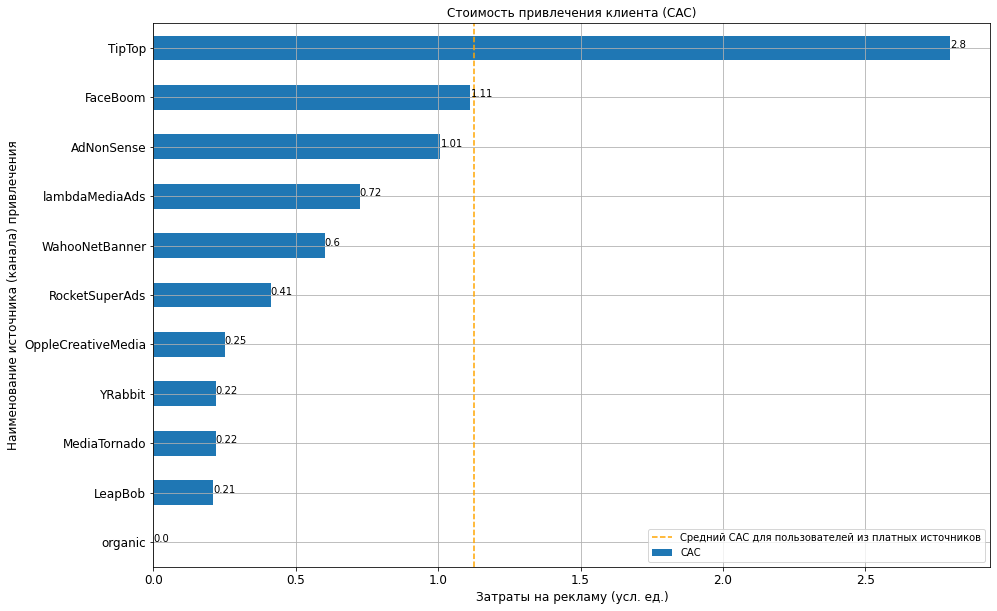

In [71]:
cac_channel = profiles.groupby('channel')['acquisition_cost'].mean().sort_values()

# средний CAC для платных источников.
mean_cac_channel = profiles.query('channel != "organic"')['acquisition_cost'].mean()

cac_channel.plot(
    kind='barh',
    figsize=(15,10),
    grid=True,
    fontsize=12
)

for i, val in enumerate(cac_channel.values):
    plt.text(val, i, round(float(val), 2))

plt.axvline(x=mean_cac_channel, ls='--', color='orange', label='Средний CAC для пользователей из платных источников')

plt.title('Cтоимость привлечения клиента (CAC)', fontsize=12)
plt.xlabel('Затраты на рекламу (усл. ед.)', fontsize=12)
plt.ylabel('Наименование источника (канала) привлечения', fontsize=12)
plt.legend(['Средний CAC для пользователей из платных источников', 'САС'],loc=0)
plt.show()  

<b> Вывод: </b> Наиболее дорогим в среднем является канал TipTop, САС по которому в несколько раз превышает САС остальных источников, и является единственным источником САС которого превышает общий средний САС. Следует провести более детальный анализ окупаемости рекламы в т.ч. в разрезе различных категорий.

<b> По результатам маркетингового анализа можно сделает промежуточные выводы:</b>
- общая сумма затрат на рекламу составила порядка 105 тыс. усл. ед.
- затраты на 2 рекламных канала (TipTop, FaceBoom) в рамках анализируемого периода существенно выросли (в 6 и 3 раза соответственно).
- общая сумма затрат на TipTop превышает 50% от общего объема затрат, а на TipTop и FaceBoom (суммарно) - 80% общего объема затрат на рекламу.
- средняя стоимость привлечения одного пользователя (САС) у TipTop является наиболее высокой и превышает САС для FaceBoom фактически в 3 раза (равно как и САС для всех остальных источников).

<a id="ads"></a>
# Проанализируем окупаемость рекламы

In [73]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [74]:
# расчет LTV и ROI с помощью заданных функций
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days
)

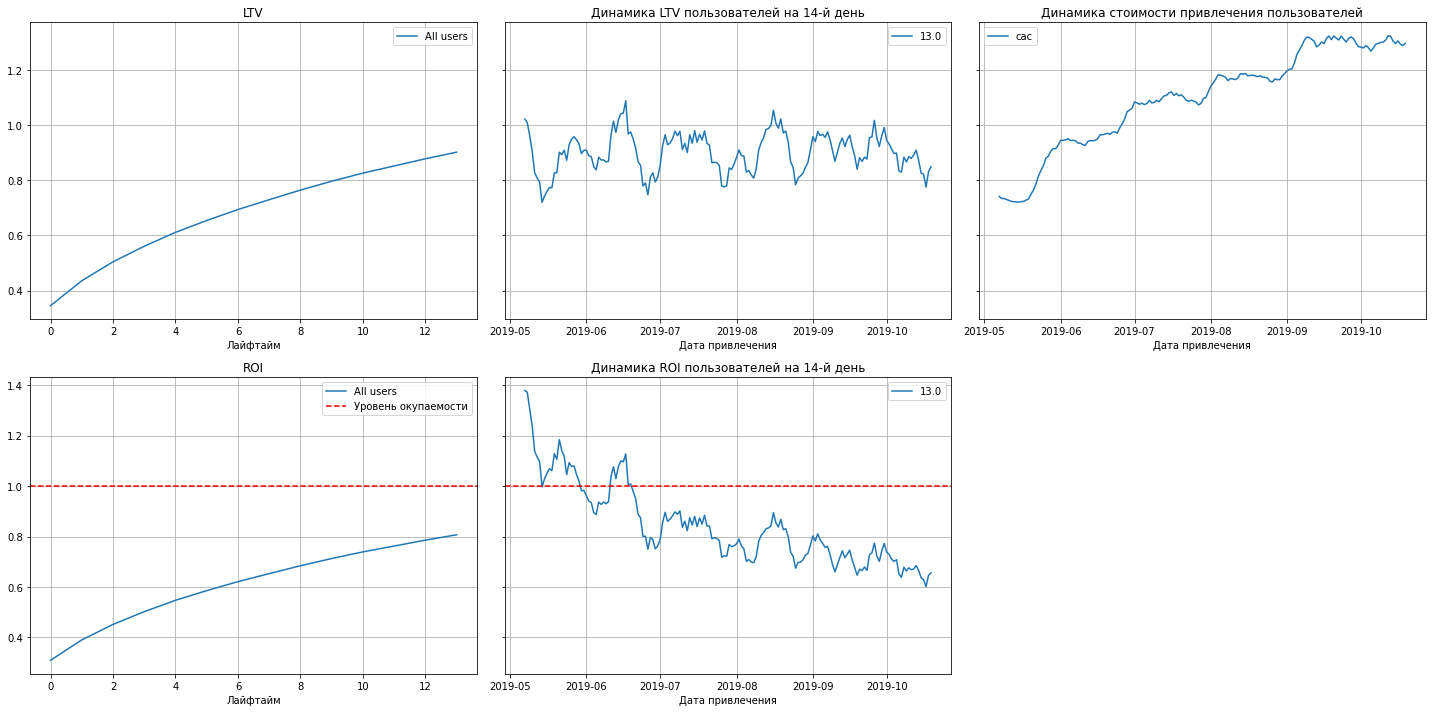

In [75]:
# построение графиков с помощью функции
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<b> Вывод: </b> реклама не окупается, о чем свидетельствует график roi. Причиной данного факта является удорожание стоимости привлечения пользователей на всем анализируемом периоде. Затраты пользователей колеблются незначительно и являются стабильными, а вот динамика roi пользователей на 14-й день обратно пропорциональна динамике САС.

<b> Конверсия и удержание пользователей

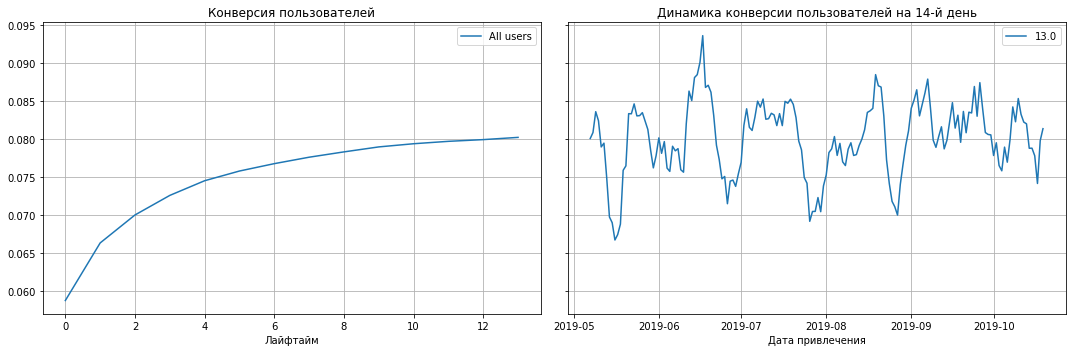

In [76]:
# общая конверсия пользователей

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

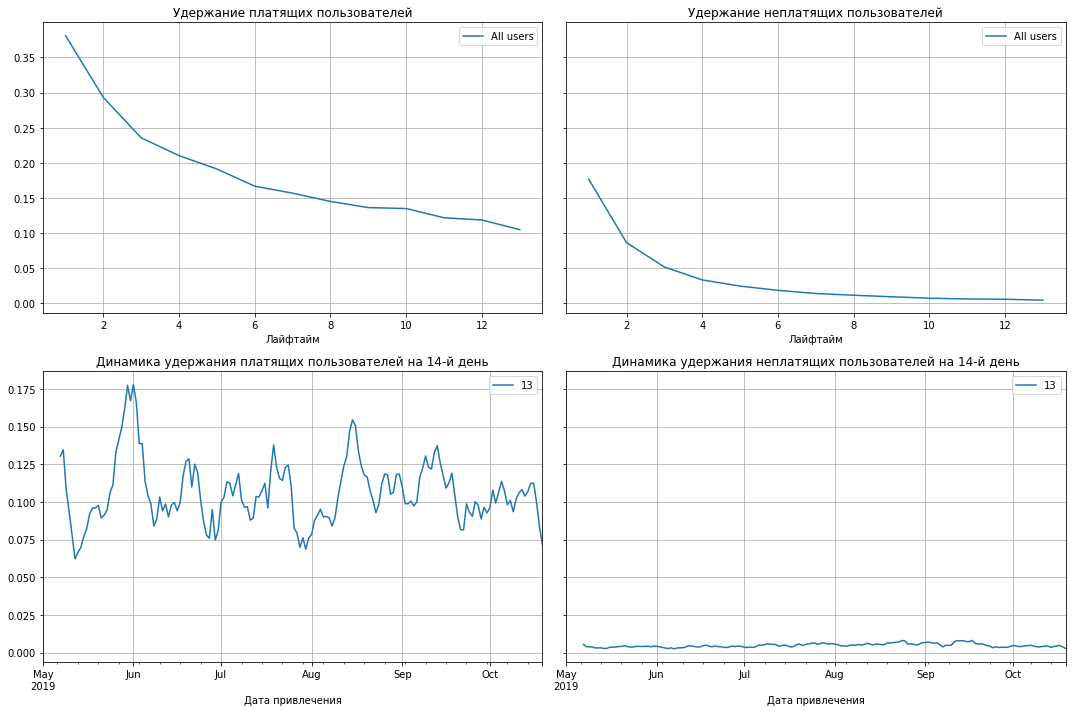

In [77]:
# общее удержание пользователей

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

<b> Вывод: </b>Конверсия выходит на значения чуть более 8% к 14 дню, что означает: после 14 дней жизни вероятность конвертировать пользователя в платящего пользователя незначительна (менее 10%). Конверсия в мае незначительно увеличилась, в дальнейшем тренд фактически стабилен. Удержание неплатящих пользователей ниже, чем платящих, что соответствует стандартной ситуации при анализе данных показателей. Удержание платящих пользователей имеет незначительный тренд на снижение. Возможно, необходимо рассмотреть варианты как удержать клиентов на более длительный срок. На плато чуть выше нуля (в пределах 0-1%) удержание неплатящих пользователей выходит на 10 день жизни пользователей, уровень удержания неплатящих пользователей является очень низким.

<b> Окупаемость в разрезе устройств. Конверсия и удержание пользователей в разрезе устройств.

Зададим параметр dimensions в разрезе которого будем анализировать окупаемость = device (устройство)

In [78]:
dimensions = ['device']

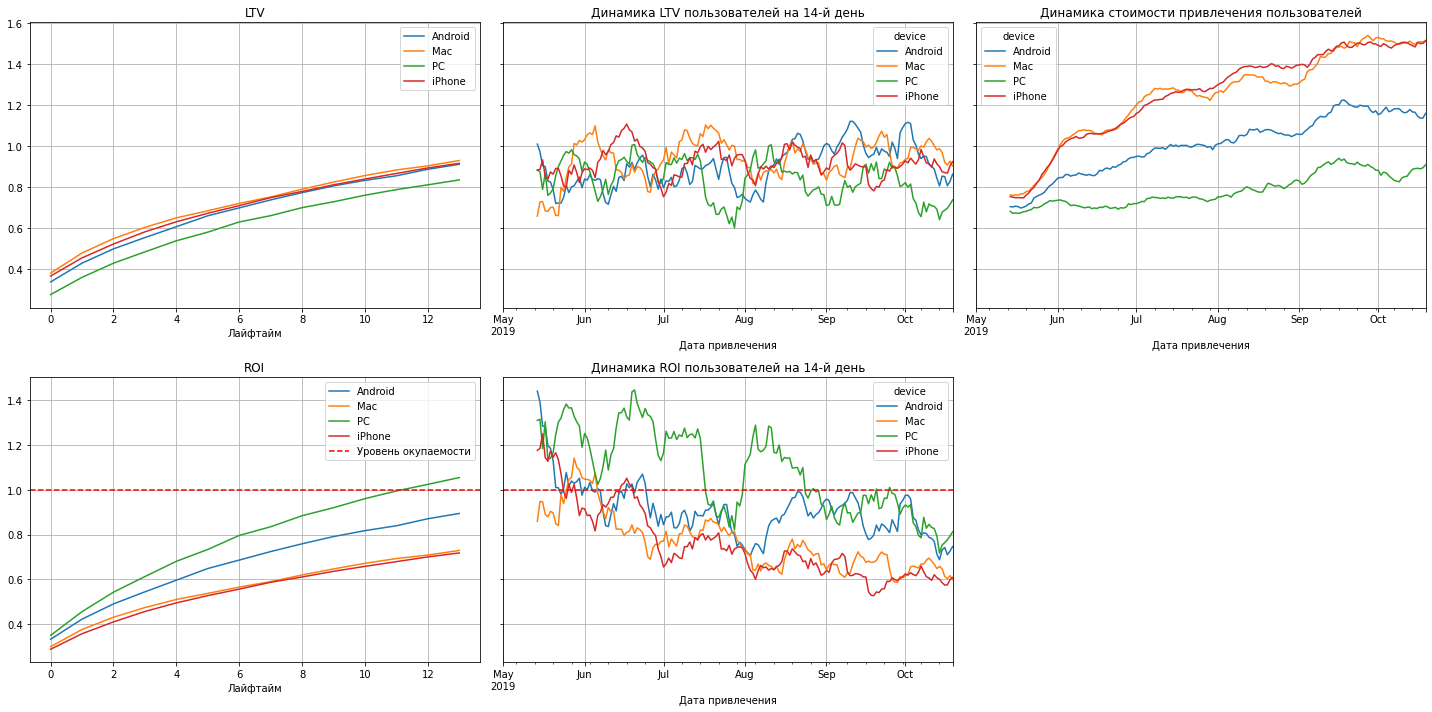

In [79]:
# расчет LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Дополнительно сразу проанализируем конверсию и удержание в разрезе устройств

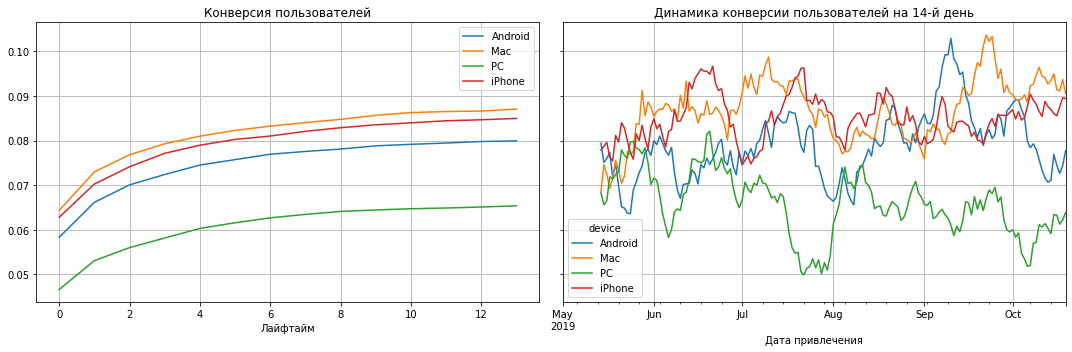

In [81]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

<b> Оценим удержание в разрезе устройств

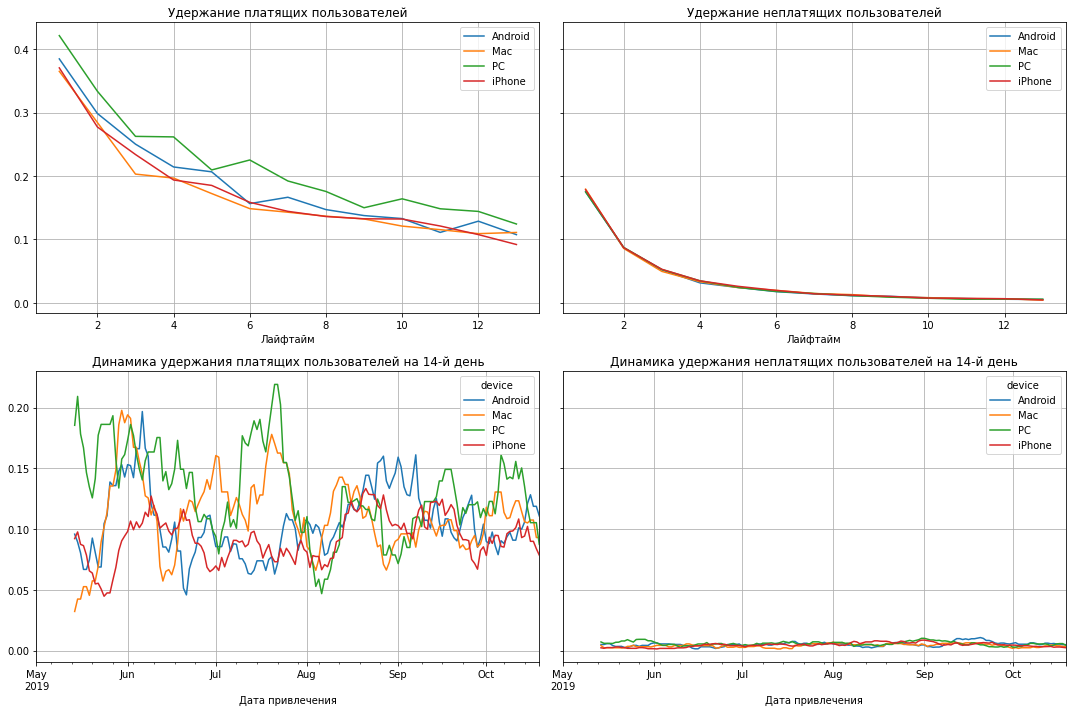

In [83]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days, window = 14) 

<b> Выводы: </b> 
- стоимость привлечения пользователей, пользующихся техникой Apple, обходится нам дороже (в 1,5-2 раза), чем привлечение остальных пользователей. 
- LTV у пользователей всех устройств находится примерно на одном уровне. У пользователей PC LTV незначительно ниже, однако за счет более низкой стоимости привлечения таких пользователей реклама по ним окупается на 11-12 день жизни пользователя (единственное устройство, по которому реклама окупалась). Однако со второй половины сентября перестают окупаться и пользователи на PC.
- конверсия на PC намного ниже, чем на других устройствах, а вот удержание незначительно выше остальных (отрыв от остальных девайсов при этом в части удержания несущественен).
- сделать более глобальные выводы, исходя исключительно из имеющихся графиков является затруднительным, поэтому продолжим анализировать данные в разрезе иных категорий.

<b> Окупаемость в разрезе стран. Конверсия и удержание пользователей в разрезе стран.

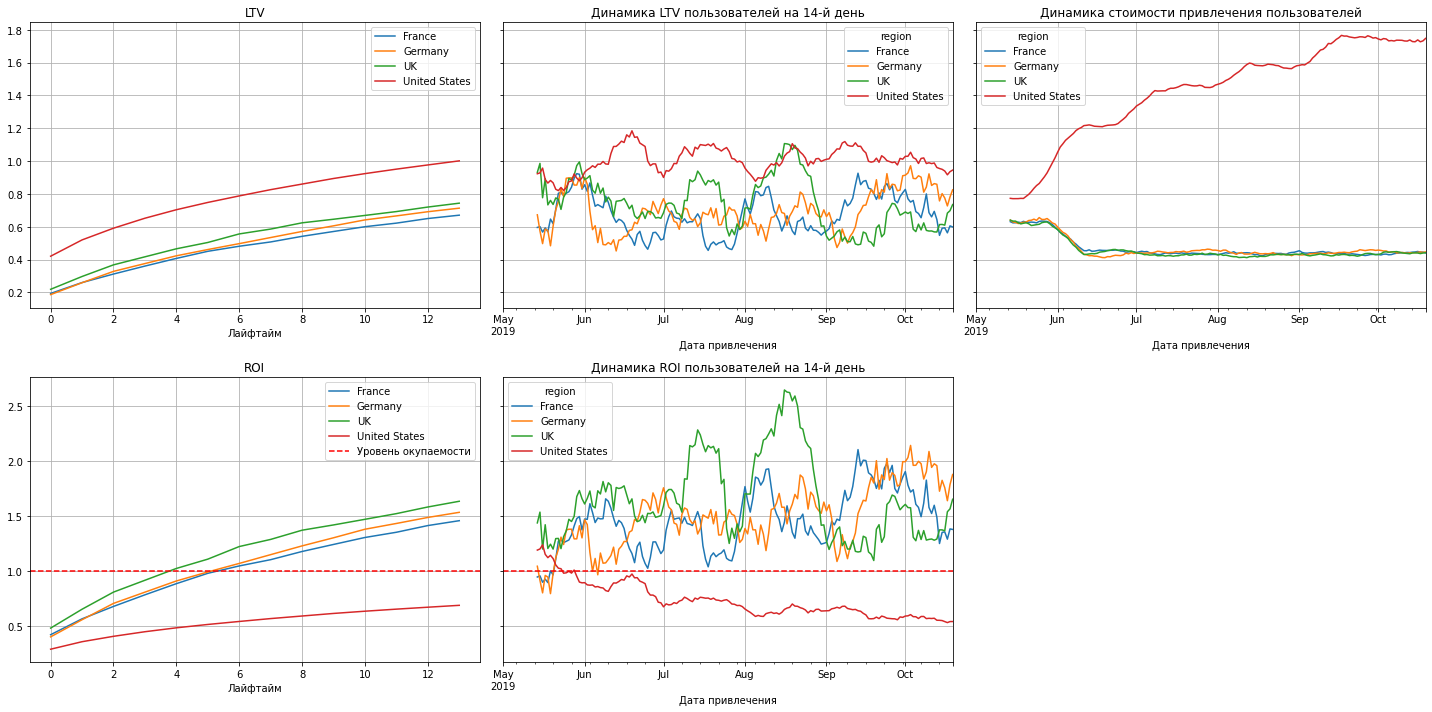

In [85]:
# расчет LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region']
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

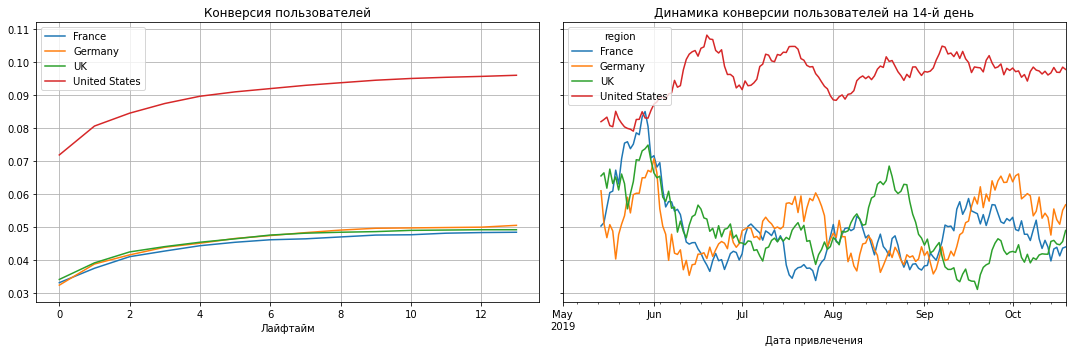

In [87]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

<b> Удержание в разрезе стран

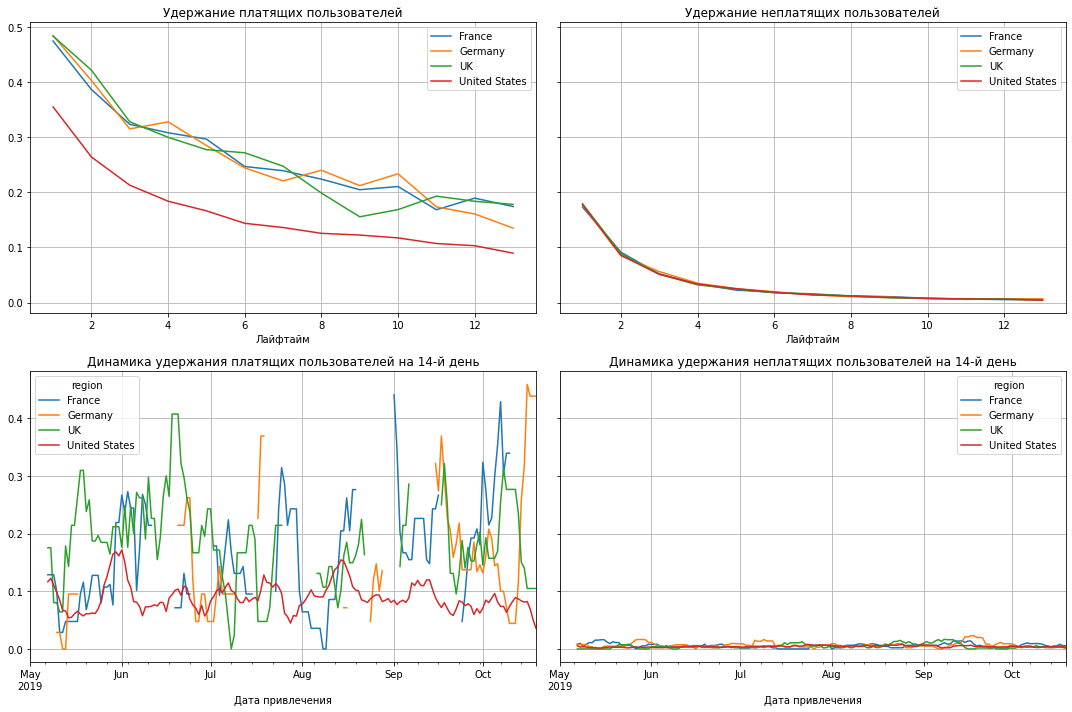

In [89]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days) 

<b> Выводы: </b> 
- конверсия пользователей в США в 2 раза выше, чем в остальных странах (Европа).
- кроме того, пользователи из США тратят на наше приложение больше остальных пользователей, однако за счет очень дорогих каналов привлечения данных пользователей они являются единственными убыточными для компании (LTV в США превышает остальные страны приблизительно на 30%, в то время как САС превышает остальные регионы в 4 раза). При этом в начале анализируемого периода пользователи из штатов окупались, необходимо провести доп. анализ в разрезе каналов привлечения пользователей.
- реклама же в европейских странах стала дешевле и пользователи в Европе окупаются к 4-5 дню жизни;
- конверсия в европейских странах с начала лета 2019 имеет незначительный тренд на снижение, в части ROI присутствует всплеск в летний период в Великобритании, о причинах которого возможно стоит поговорить с маркетологами с т.зр. изменений, предпринятых в маркетинговой стратегии в регионе в данный период, попутно изучив данные в остальных срезах. 
- ROI в европейских странах имеет тренд к росту с начала лета 2019, что обусловлено сокращением САС темпами большими, нежели снижение конверсии.

<b> Окупаемость в разрезе по рекламным каналам. Конверсия и удержание пользователей в разрезе по рекламным каналам.

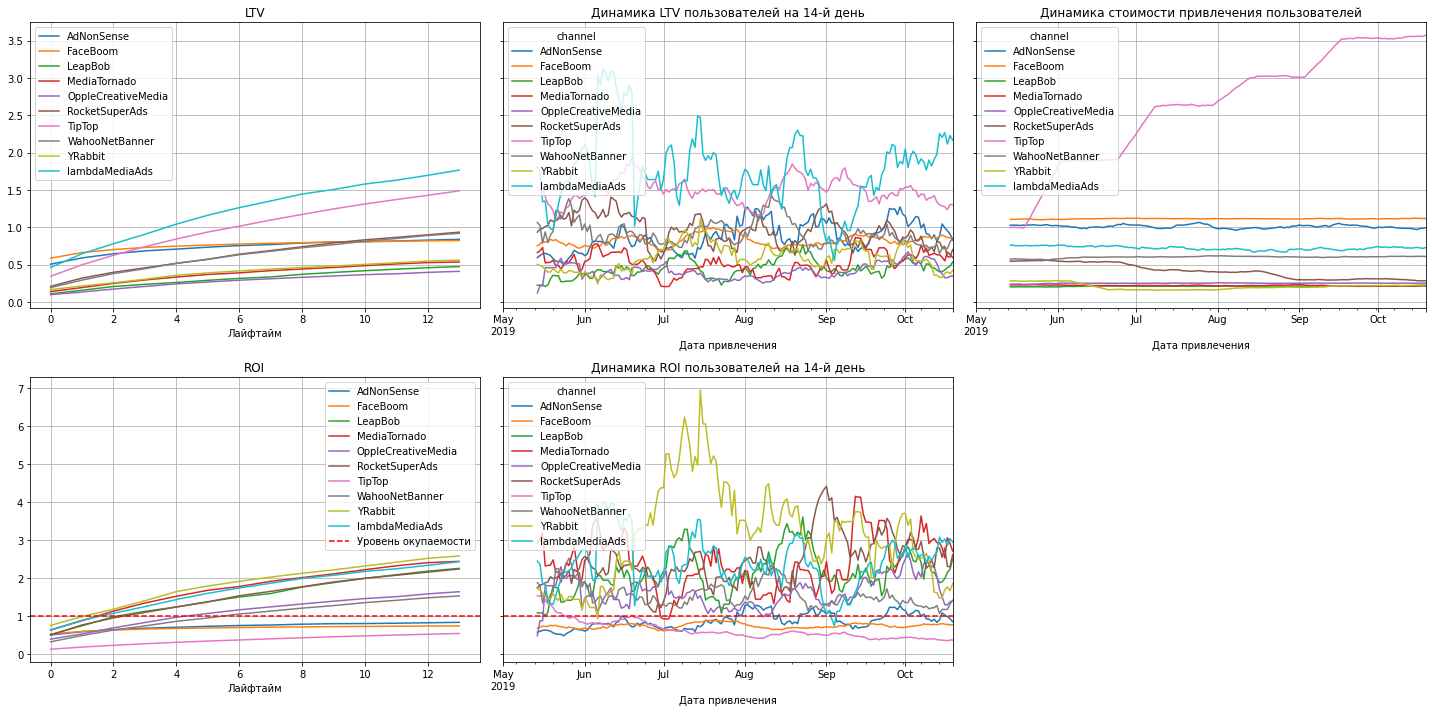

In [91]:
# расчет LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

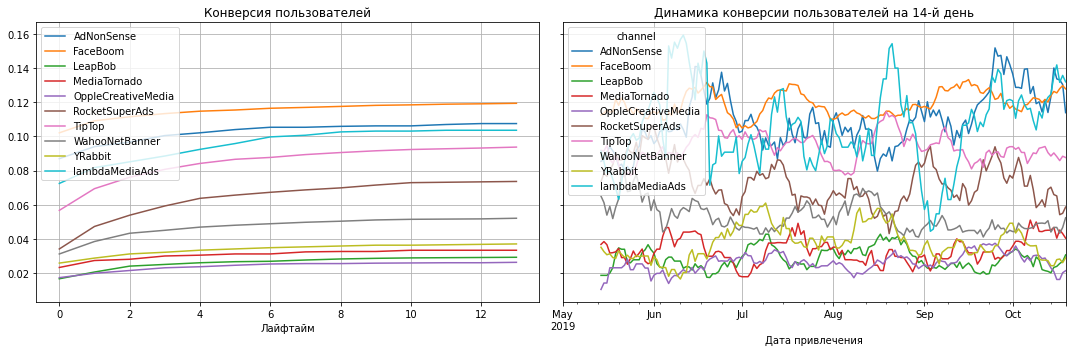

In [93]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

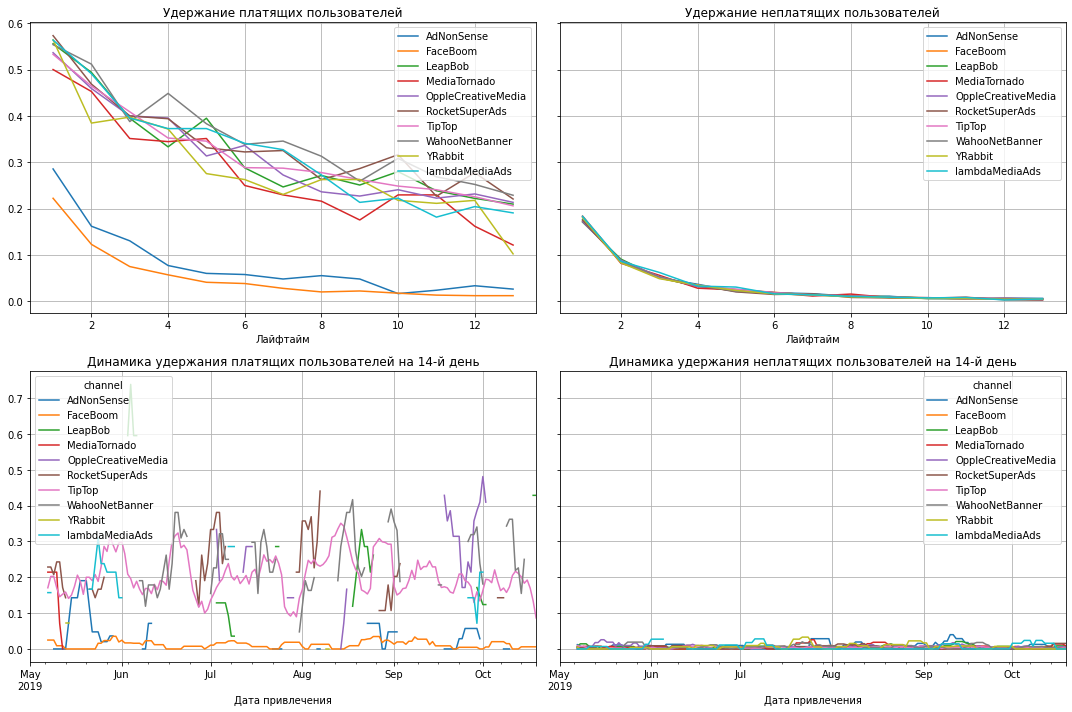

In [95]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

<b> Выводы: </b> 
- с точки зрения ltv лидерами "с запасом" являются LambdaMediaAds и TipTop.
- самой высокой конверсией обладают пользователи, привлеченные из FaceBoom, AdNonSense, LamdaMediaAds, TipTop. А самой низкой конверсией OppleCreativeMedia, LeapBob, YRabbit, MediaTornado.
- в части удержания у нас имеются два явных аутсайдера (FaceBoom и AdNonSense).
- стоимость привлечения через TipTop выросла в разы, существенно превысив САС по всем остальным каналам.
- убыточными в свою очередь являются 3 канала привлечения пользователей: AdNonSense, FaceBoom, TipTop (темпы роста конверсии по TipTop в разы ниже темпов роста САС по данному каналу). 
- наиболее выгодными каналами привлечения пользователей являются - YRabbit, MediaTornado, LambdaMediaAds, LeapBob, RocketSuperAds. 
- по yRabbit отмечается существенный роста ROI в июле с последующим его снижением до ретроуровня, что частично может быть обусловлено снижением САС в данный период по каналу и ростом конверсии, однако для более точных выводов считаем необходимым запросить информацию у отдела маркетинга, т.к. динамика изменений в отношении канала на других графиках и рынках (yRabbit - рынок США) не раскрывает в полной мере причины столь существенного роста roi (с нашей точки зрения).


<b> Окупаемость, конверсия и удержание в США

In [96]:
profiles_usa = profiles.query('region == "United States"')

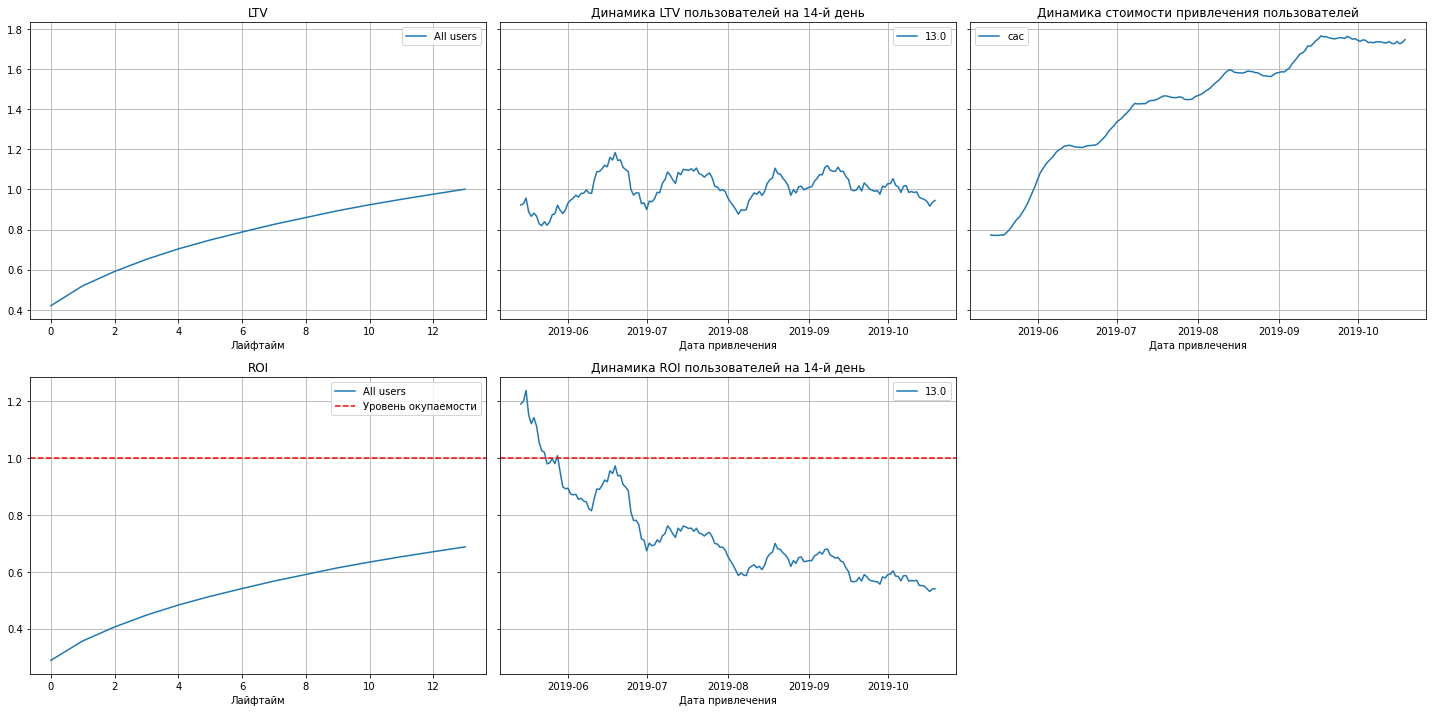

In [97]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    horizon_days,
    dimensions=[]
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

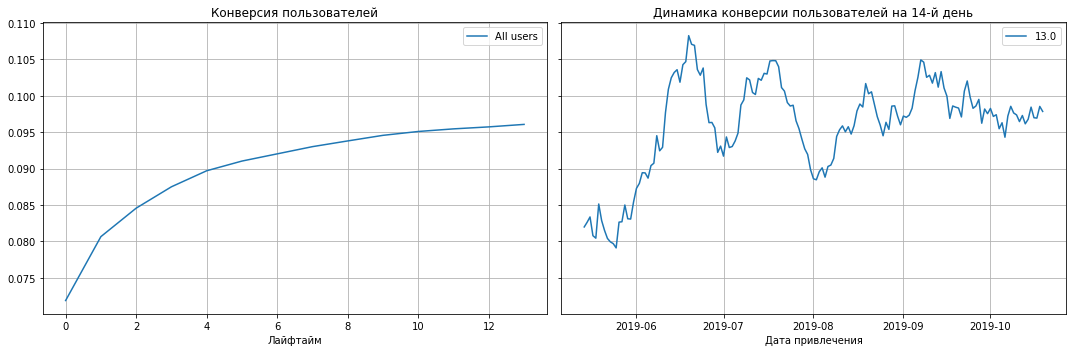

In [98]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=[])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

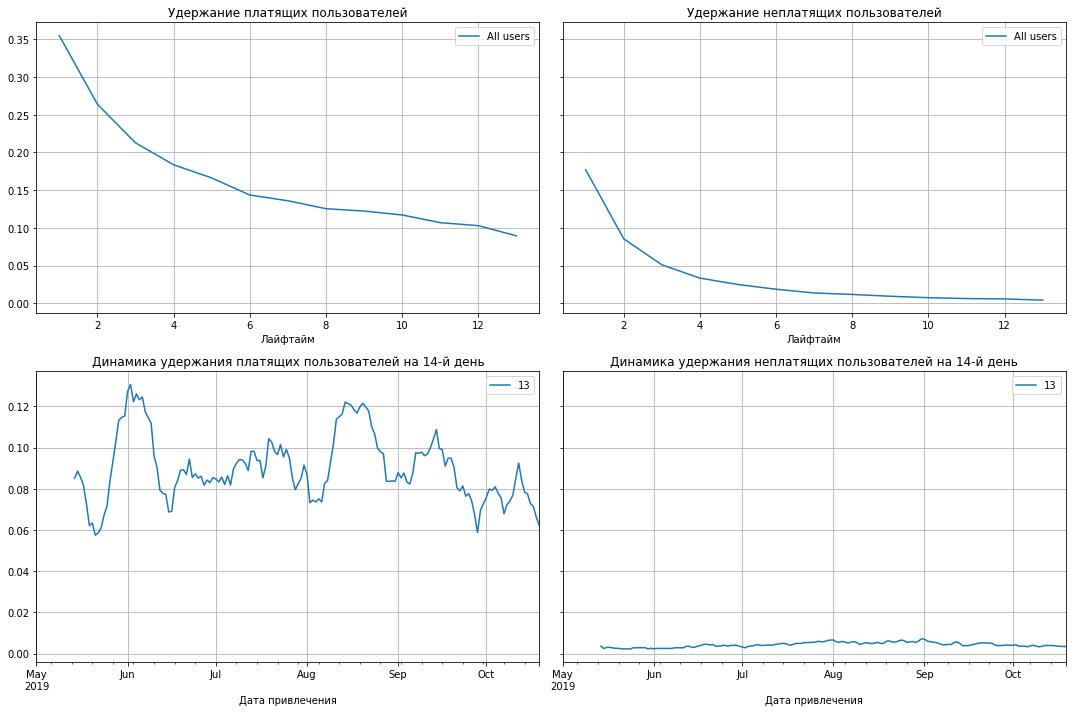

In [99]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=[])

plot_retention(retention_grouped, retention_history, horizon_days, window = 14) 

Графики выше подтверждают выявленные нами ранее тенденции, отдельно повторно стоит отметить, что конверсия имеет тренд к росту, при том, что удержание имеет тренд к незначительному снижению.

Проанализируем рынок США в разрезе рекламных каналов и девайсов с т.зр. окупаемости, конверсии и удержания.

<b> в разрезе рекламных каналов

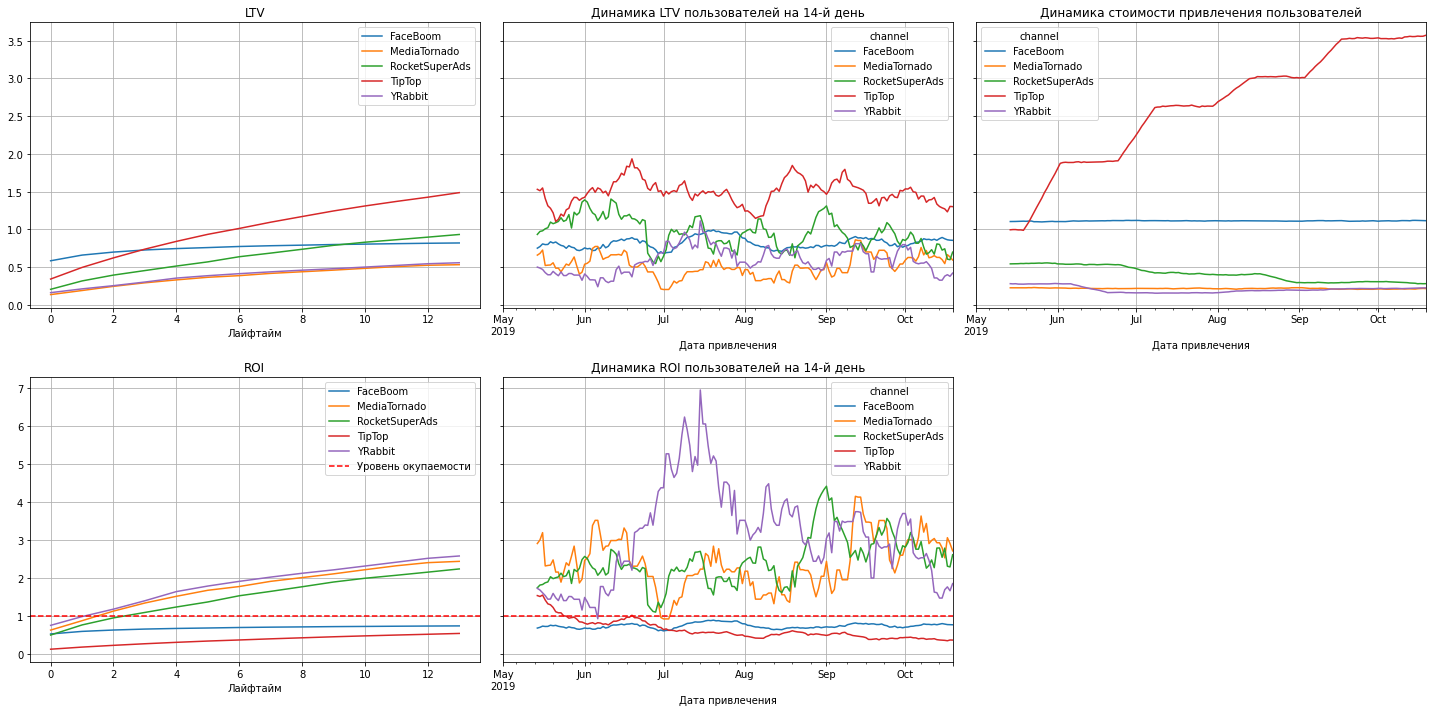

In [101]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

<b> конверсия (рекламные каналы)

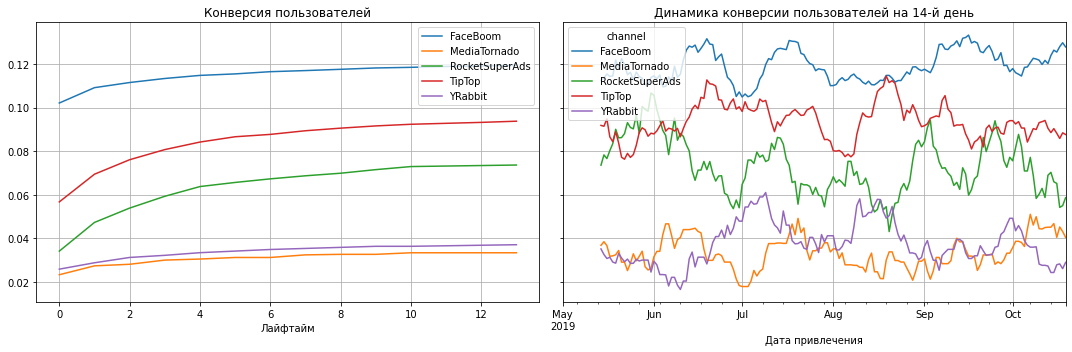

In [103]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

<b> удержание (рекламные каналы)

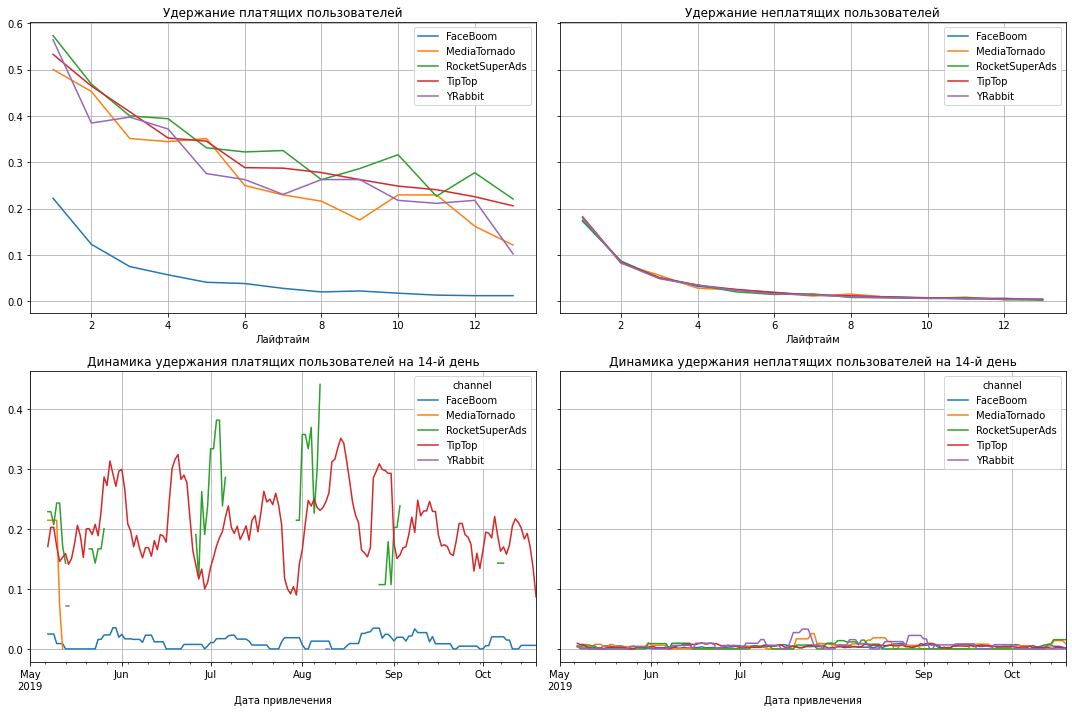

In [105]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

<b> в разрезе устройств

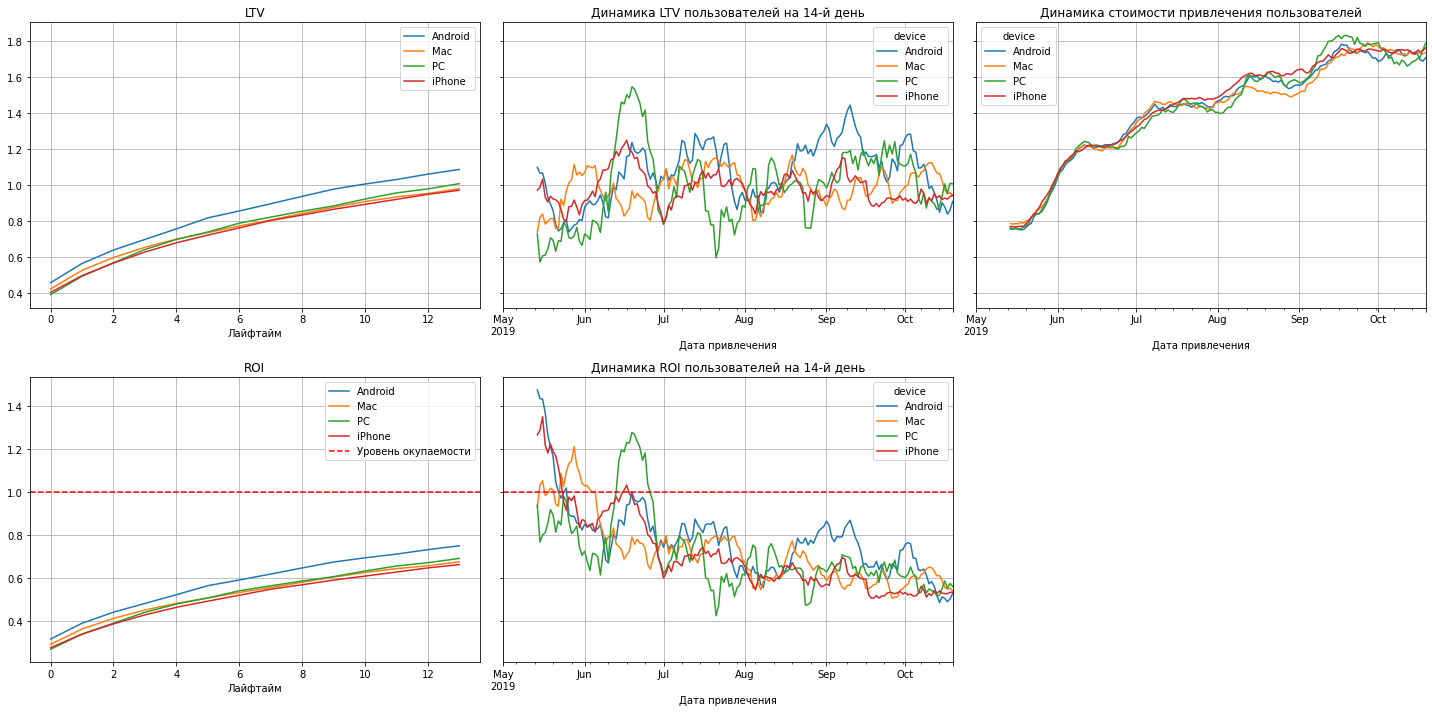

In [107]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device']
)

# построение графиков 
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

<b> конверсия (устройства)

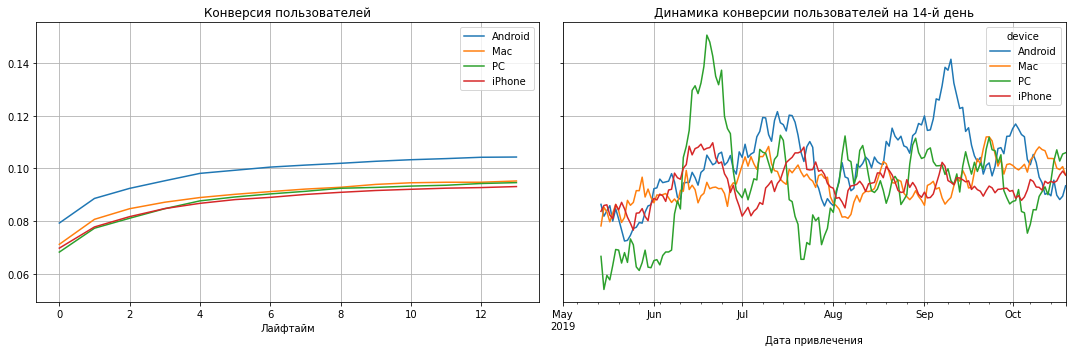

In [109]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

<b> удержание (устройства)

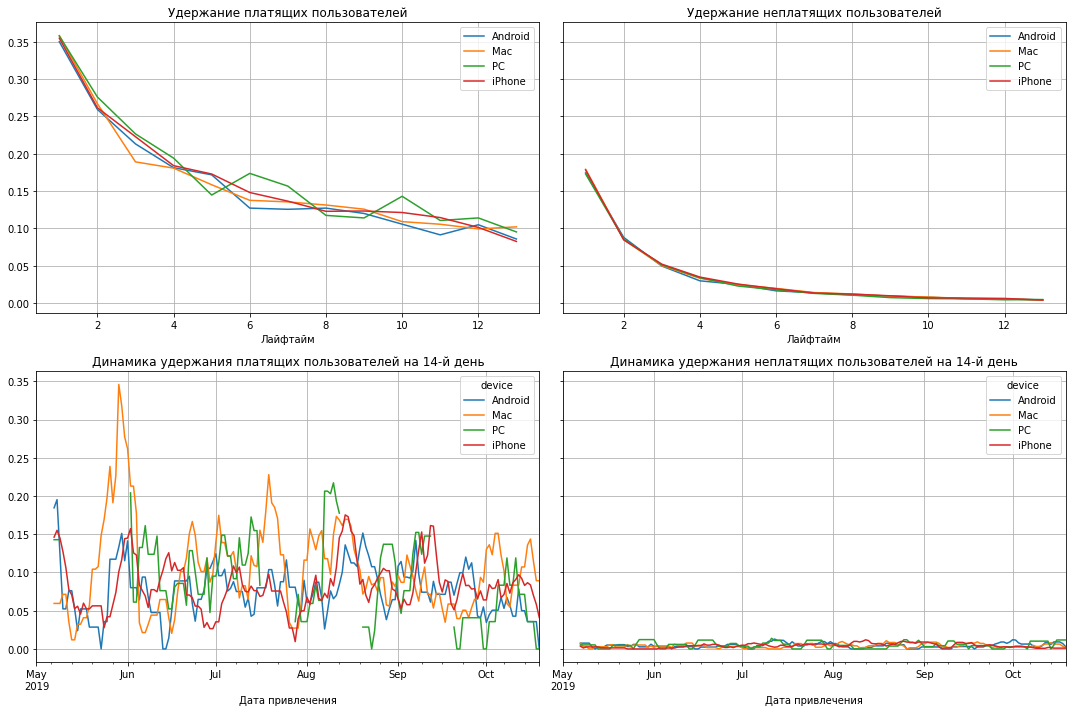

In [111]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days) 

<b> Выводы по региональным рынкам: </b>
- два убыточных в общем канала (TipTop и Faceboom) являются лидерами по привлечению клиентов в США (и единственными убыточными на данном рынке). В связи с этим данный регион по окупаемости рекламы показывает себя с наихудшей стороны. 
- наиболее прибыльным каналом на рынке США являются YRabbit и MediaTornado.
- динамика САС в разрезе каналов по сути повторяет ранее построенные графики.
- на европейсом рынке ситуация с окупаемостью рекламы лучше, нежели в США. Убыточным является только канал AdNonSense. Самыми экономически выгодными каналами являются LamdaMediaAds и LeapBob.

<a id="conclusion"></a>
<b> Общий вывод: </b>
- конверсия в США ниже чем в Европе, что обусловлено низкой конверсией в канале FaceBoom. Пользователи, которых мы привлекаем через это приложение, надолго не задерживаются в приложении.
- LTV у клиентов из США выше, чем у клиентов из Европы, но за счет существенных САС (в разы превышающих САС на европейском рынке) рынок США убыточен.
- FaceBoom и TipTop, несмотря на высокую конверсию, являются убыточными, а график изменения САС во многом повторяет график изменения САС для TipTop, т.к. динамика САС по остальным каналам относительна стабильна.
- на европейском рынке денежные средства, вложенные в рекламу окупаются, однако стоит обратить внимание на канал AdNonSense, который является убыточным, потенциально за счет низкого уровня удержания пользователей и более высоких САС по сравнению с другими каналами.

<b> Рекомендации: </b>
- на американском рынке следует координально пересмотреть стратегию работы с FaceBoom и TipTop: сократить работу с ними до минимума, либо отказаться от них (в случае продолжения работы с данными каналами: по FaceBoom основным направление работы мы видим проведение мероприятий по увеличению удержания пользователей из канала и выяснение причин столь низкого удержания в целом, в части TipTop - координальное изменение рекламного бюджета и ценовых параметров работы в канале). Пристальное внимание стоит обратить на RocketSuperAds (канал с достаточно высокой конверсией и невысокой ценой привлечения клиентов).
- на европейском рынке следует обратить внимание на LamdaMediaAds (канал с высокой конверсией и самой высокой окупаемостью рекламы в Европе). Также следует пересмотреть стратегию работы с AdNonSense или отказаться от работы с каналом.
- слабая конверсия у пользователей PC может свидетельствовать о каких-то проблемах в части работы приложения на этих устройствах, т.об., следует отдельно проанализировать работу приложения на PC.